In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
from DFL_util import dataset_model_set, create_graph_object
import os, sys
from matplotlib.font_manager import FontProperties
import textwrap
import pickle as pk

j:\TIA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def normalize(group):
    min_val = group['Value'].min()
    max_val = group['Value'].max()
    # print(f"ATTACT METRICS: {group['ATTACT METRICS'].iloc[0]}, Min: {min_val}, Max: {max_val}")
    group['Normalized_value'] = (group['Value'] - min_val) / (max_val - min_val)
    return group

In [3]:
def extract_data_from_directory(directory_path, feature_filename):
    file_path = os.path.join(directory_path, f'{feature_filename}.csv')
    print(file_path)
    # files = sorted(glob.glob(file_pattern))
    
    # if not files:
    #   raise FileNotFoundError(f"No files found in the directory {directory_path} matching the pattern {files}")
    
    df = pd.read_csv(file_path,index_col=0) # here since we only extract from Round_9, so the files is single.
    
    return df

In [4]:
# path = 'j:\\TIA\\TIA\\saved_metrics\\FMnist_mlp_star_1_0.1_42_10_10\\_entropy_metric.csv'
# df = pd.read_csv(path,index_col=0)
# df

In [4]:
def _data_prepare(data, graph):
    data = np.array(data.iloc[0:, 0:].values, dtype=float)
    num_nodes = data.shape[0]
    
    # Check if the data matrix is symmetric
    is_symmetric = np.allclose(data, data.T)
    
    # Prepare features and labels
    X = []
    y = []
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:  # Skip diagonal (self-connection)
                # If the matrix is symmetric, only process one side of the diagonal
                if is_symmetric and i < j:
                    # Feature vector for node pair (i, j)
                    feature_vector = [data[i, j]]
                    X.append(feature_vector)
                    
                    # Label: 1 if there is an edge between nodes i and j, 0 otherwise
                    if graph.has_edge(i, j):
                        y.append(1)  # Direct link in the graph
                    else:
                        y.append(0)  # No direct link in the graph
    
                # If the matrix is asymmetric, process both sides
                elif not is_symmetric:
                    # Feature vector for node pair (i, j)
                    feature_vector = [data[i, j]]
                    X.append(feature_vector)
    
                    # Label: 1 if there is an edge between nodes i and j, 0 otherwise
                    if graph.has_edge(i, j):
                        y.append(1)  # Direct link in the graph
                    else:
                        y.append(0)  # No direct link in the graph
    
    # Convert X and y to NumPy arrays
    X = np.array(X).flatten()
    y = np.array(y)
    
    return X , y

In [6]:
# DATASET = ["Mnist", "Cifar10no"]
# TOPOLOGY = ["star", "ring", "ER_0.5"]
# MODEL = ["mlp", "mobile"]
# MAX_EPOCHS = [10]
# METRICS = ["Average_Loss", "Cosine_Similarity", "Euclidean_Distance", "Average_Entropy"]
# NUM = 10 
# ROUND = 9

# IID = 1    
# ALPHA = 0.1 
# SEED = 42

In [15]:
DATASET = ["Cifar10no", "Cifar10", "Mnist","FMnist", "imagenet10", "pcam", "svhn"]
TOPOLOGY = ["star", "ring","ER_0.3", "ER_0.5", "ER_0.7",'Abilene', 'GÉANT', 'synth50', 'rf1755', 'rf3967', 'atlanta', 'brain', 'cost266', 'dfn-bwin', 'dfn-gwin', 'di-yuan', 'france',  'germany50', 'giul39', 'india35', 'janos-us', 'janos-us-ca', 'newyork', 'nobel-eu', 'nobel-germany', 'nobel-us', 'norway', 'pdh', 'pioro40', 'polska', 'sun', 'ta1', 'ta2', 'zib54']
# TOPOLOGY = ["star", "ring","ER_0.3", "ER_0.5", "ER_0.7"]
MODEL = ["mlp", "mobile", "resnet","pf"]
MAX_EPOCHS = [3]
METRICS = ['_cosine_metric', '_curvature_divergence', '_entropy_metric', '_euclidean_metric', '_jacobian_metric', '_loss_metric']
# NUM = 10 
# ROUND = 9
NUM_CLIENTS = [10, 20,30,12,22,50,79,87, 15, 161, 37, 11, 25, 35, 26, 39, 16, 28, 17, 14,  40,  27, 24, 65, 54]
IID = 1    
ALPHA = 0.1 
SEED = 42

In [16]:
dataset = DATASET[4]
model_name = MODEL[3]
topo = TOPOLOGY[0]
num = 20
IID = 1    
ALPHA = 0.1 
SEED = 42
MAX_EPOCHS = [3]
max_epoch = 3

In [7]:
cur_dir = os.getcwd()
topology_path = f"{cur_dir}/topologies/"

In [8]:
def get_plot_data(dataset, model_name, topo, max_epoch, num):
    case_dict = {} 
    toponame_file = f"{topology_path}/{num}_{topo}.pk"
    if os.path.exists(toponame_file):  
        with open(toponame_file, "rb") as f:
            G = pk.load(f)
    else:
        return None
    
    try:
        for metric in METRICS:
            if metric == "_loss_metric":
                metric_n = "Relative Loss"
            elif metric == "_cosine_metric":
                metric_n = "Cosine Similarity"
            elif metric == "_entropy_metric":
                metric_n = "Relative Entropy"
            elif metric == "_euclidean_metric":
                metric_n = "Euclidean Similarity"
            elif metric == "_curvature_divergence":
                metric_n = "Curvature Divergence"
            elif metric == "_jacobian_metric":
                metric_n = "Relative Sensitivity"
                    
            case_dict[metric_n]=[]
                            
            # G = create_graph_object(NUM, topo)         
            
        
            file_name = dataset + "_" + model_name + "_" + topo + "_" + str(IID) + "_" + str(ALPHA) + "_" + str(SEED) + "_" + str(max_epoch)+ "_" + str(num)
            file_path = os.path.join(cur_dir, f"saved_metrics\\{file_name}\\")
            
            FL_data = extract_data_from_directory(file_path, metric)
            
            X, y = _data_prepare(FL_data, G)
            
            edge_group = X[y == 1]
            non_edge_group = X[y == 0]           
        
            case_dict[metric_n].append(edge_group)
            case_dict[metric_n].append(non_edge_group)
            
        data  =  case_dict
        plot_data = {
            'ATTACT METRICS': ['Relative Loss'] * (len(data['Relative Loss'][0]) + len(data['Relative Loss'][1])) +
                            ['Relative Entropy'] * (len(data['Relative Entropy'][0]) + len(data['Relative Entropy'][1]))+
                            ['Relative Sensitivity'] * (len(data['Relative Sensitivity'][0]) + len(data['Relative Sensitivity'][1])) +
                        ['Cosine Similarity'] * (len(data['Cosine Similarity'][0]) + len(data['Cosine Similarity'][1])) +                                                            
                        ['Euclidean Similarity'] * (len(data['Euclidean Similarity'][0]) + len(data['Euclidean Similarity'][1])) +
                        ['Curvature Divergence'] * (len(data['Curvature Divergence'][0]) + len(data['Curvature Divergence'][1])),
                        
            
            f'{topo}': np.concatenate([data['Relative Loss'][0], data['Relative Loss'][1],
                                    data['Relative Entropy'][0], data['Relative Entropy'][1],
                                    data['Relative Sensitivity'][0], data['Relative Sensitivity'][1],
                                    data['Cosine Similarity'][0], data['Cosine Similarity'][1],                                                                                       
                                    data['Euclidean Similarity'][0], data['Euclidean Similarity'][1],
                                        data['Curvature Divergence'][0], data['Curvature Divergence'][1]]),
            
            'Connection Type': ['Edge'] * len(data['Relative Loss'][0]) + ['Non-Edge'] * len(data['Relative Loss'][1]) +
                            ['Edge'] * len(data['Relative Entropy'][0]) + ['Non-Edge'] * len(data['Relative Entropy'][1]) +
                            ['Edge'] * len(data['Relative Sensitivity'][0]) + ['Non-Edge'] * len(data['Relative Sensitivity'][1]) +
                            ['Edge'] * len(data['Cosine Similarity'][0]) + ['Non-Edge'] * len(data['Cosine Similarity'][1]) +                                                                      
                            ['Edge'] * len(data['Euclidean Similarity'][0]) + ['Non-Edge'] * len(data['Euclidean Similarity'][1]) +
                            ['Edge'] * len(data['Curvature Divergence'][0]) + ['Non-Edge'] * len(data['Curvature Divergence'][1])
                }
        df = pd.DataFrame(plot_data)
        df.columns=['ATTACT METRICS','Value','Connection Type']
        df['topo'] = f'{topo}_{num}'
        nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g))
        nor_df['Normalized_value'] = nor_df['Normalized_value'].clip(0, 1)
        return nor_df
    except:
        return None

In [101]:
df = get_plot_data(dataset, model_name, topo, max_epoch, num)

j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_20\_cosine_metric.csv
j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_20\_curvature_divergence.csv
j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_20\_entropy_metric.csv
j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_20\_euclidean_metric.csv
j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_20\_jacobian_metric.csv
j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_20\_loss_metric.csv


C:\Users\luke-\AppData\Local\Temp\ipykernel_7948\361357108.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g))


In [104]:
nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(normalize)
nor_df['Normalized_value'] = nor_df['Normalized_value'].clip(0, 1)


C:\Users\luke-\AppData\Local\Temp\ipykernel_7948\836976950.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(normalize)


In [103]:
nor_df = large_df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g))
nor_df['Normalized_value'] = nor_df['Normalized_value'].clip(0, 1)

C:\Users\luke-\AppData\Local\Temp\ipykernel_7948\3156502652.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nor_df = large_df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g))


In [105]:
nor_df['Connection Type']= nor_df['Connection Type'].apply(str.upper)
nor_df['ATTACT METRICS']= nor_df['ATTACT METRICS'].apply(str.upper)

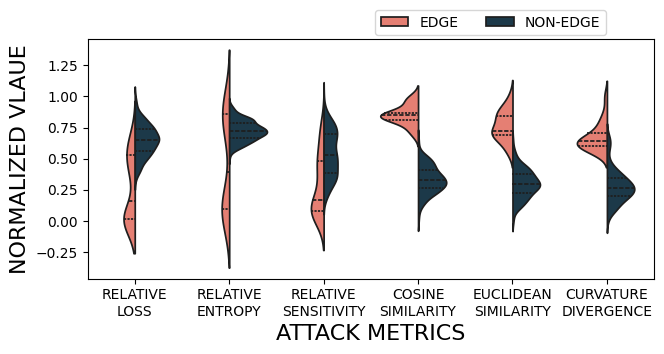

In [107]:
plt.figure(figsize=(7,4))
palette = ['#F87060','#153B50' ] 
sns.violinplot(data=nor_df, x='ATTACT METRICS', y='Normalized_value', hue='Connection Type', palette=palette, split=True, inner='quartile')

plt.legend(loc='upper left', bbox_to_anchor=(0.495, 1.15), ncol=2)

wrapped_labels = [textwrap.fill(label.upper(), 11) for label in nor_df['ATTACT METRICS'].unique()]
plt.xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, rotation=0)


plt.xlabel('ATTACK METRICS', fontsize=16)  
plt.ylabel('NORMALIZED VLAUE', fontsize=16)
# plt.ylim(0, 1)
plt.tight_layout(pad=2.0, w_pad=2.5, h_pad=1.0)
plt.savefig('metrics_distribution.pdf')

In [17]:
df_list = []
for topo in TOPOLOGY:
    for num in NUM_CLIENTS:
        df = get_plot_data(dataset, model_name, topo, max_epoch, num)
        if df is not None:
            df_list.append(df)

j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_10\_cosine_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_10\_curvature_divergence.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_10\_entropy_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_10\_euclidean_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_10\_jacobian_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_10\_loss_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_20\_cosine_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_20\_curvature_divergence.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_20\_entropy_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_20\_euclidean_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_20\_jacobian_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3_20\_loss_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_star_1_0.1_42_3

C:\Users\luke-\AppData\Local\Temp\ipykernel_764\361357108.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g))
C:\Users\luke-\AppData\Local\Temp\ipykernel_764\361357108.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g))
C:\Users\luke-\A

j:\TIA\TIA\saved_metrics\imagenet10_pf_Abilene_1_0.1_42_3_12\_cosine_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_Abilene_1_0.1_42_3_12\_curvature_divergence.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_Abilene_1_0.1_42_3_12\_entropy_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_Abilene_1_0.1_42_3_12\_euclidean_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_Abilene_1_0.1_42_3_12\_jacobian_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_Abilene_1_0.1_42_3_12\_loss_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_GÉANT_1_0.1_42_3_22\_cosine_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_GÉANT_1_0.1_42_3_22\_curvature_divergence.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_GÉANT_1_0.1_42_3_22\_entropy_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_GÉANT_1_0.1_42_3_22\_euclidean_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_GÉANT_1_0.1_42_3_22\_jacobian_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_GÉANT_1_0.1_42_3_22\_loss_metric.csv
j:\TIA\TIA\saved_metrics\image

C:\Users\luke-\AppData\Local\Temp\ipykernel_764\361357108.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g))
C:\Users\luke-\AppData\Local\Temp\ipykernel_764\361357108.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g))
C:\Users\luke-\A

j:\TIA\TIA\saved_metrics\imagenet10_pf_brain_1_0.1_42_3_161\_entropy_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_brain_1_0.1_42_3_161\_euclidean_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_brain_1_0.1_42_3_161\_jacobian_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_brain_1_0.1_42_3_161\_loss_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_cost266_1_0.1_42_3_37\_cosine_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_dfn-bwin_1_0.1_42_3_10\_cosine_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_dfn-bwin_1_0.1_42_3_10\_curvature_divergence.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_dfn-bwin_1_0.1_42_3_10\_entropy_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_dfn-bwin_1_0.1_42_3_10\_euclidean_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_dfn-bwin_1_0.1_42_3_10\_jacobian_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_dfn-bwin_1_0.1_42_3_10\_loss_metric.csv
j:\TIA\TIA\saved_metrics\imagenet10_pf_dfn-gwin_1_0.1_42_3_11\_cosine_metric.csv
j:\TIA\TIA\saved_metri

C:\Users\luke-\AppData\Local\Temp\ipykernel_764\361357108.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g))
C:\Users\luke-\AppData\Local\Temp\ipykernel_764\361357108.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g))
C:\Users\luke-\A

In [95]:
large_df = pd.concat(df_list, ignore_index=True)

In [90]:
nor_df = large_df

C:\Users\luke-\AppData\Local\Temp\ipykernel_764\2345531081.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=2.0, w_pad=2.5, h_pad=1.0)


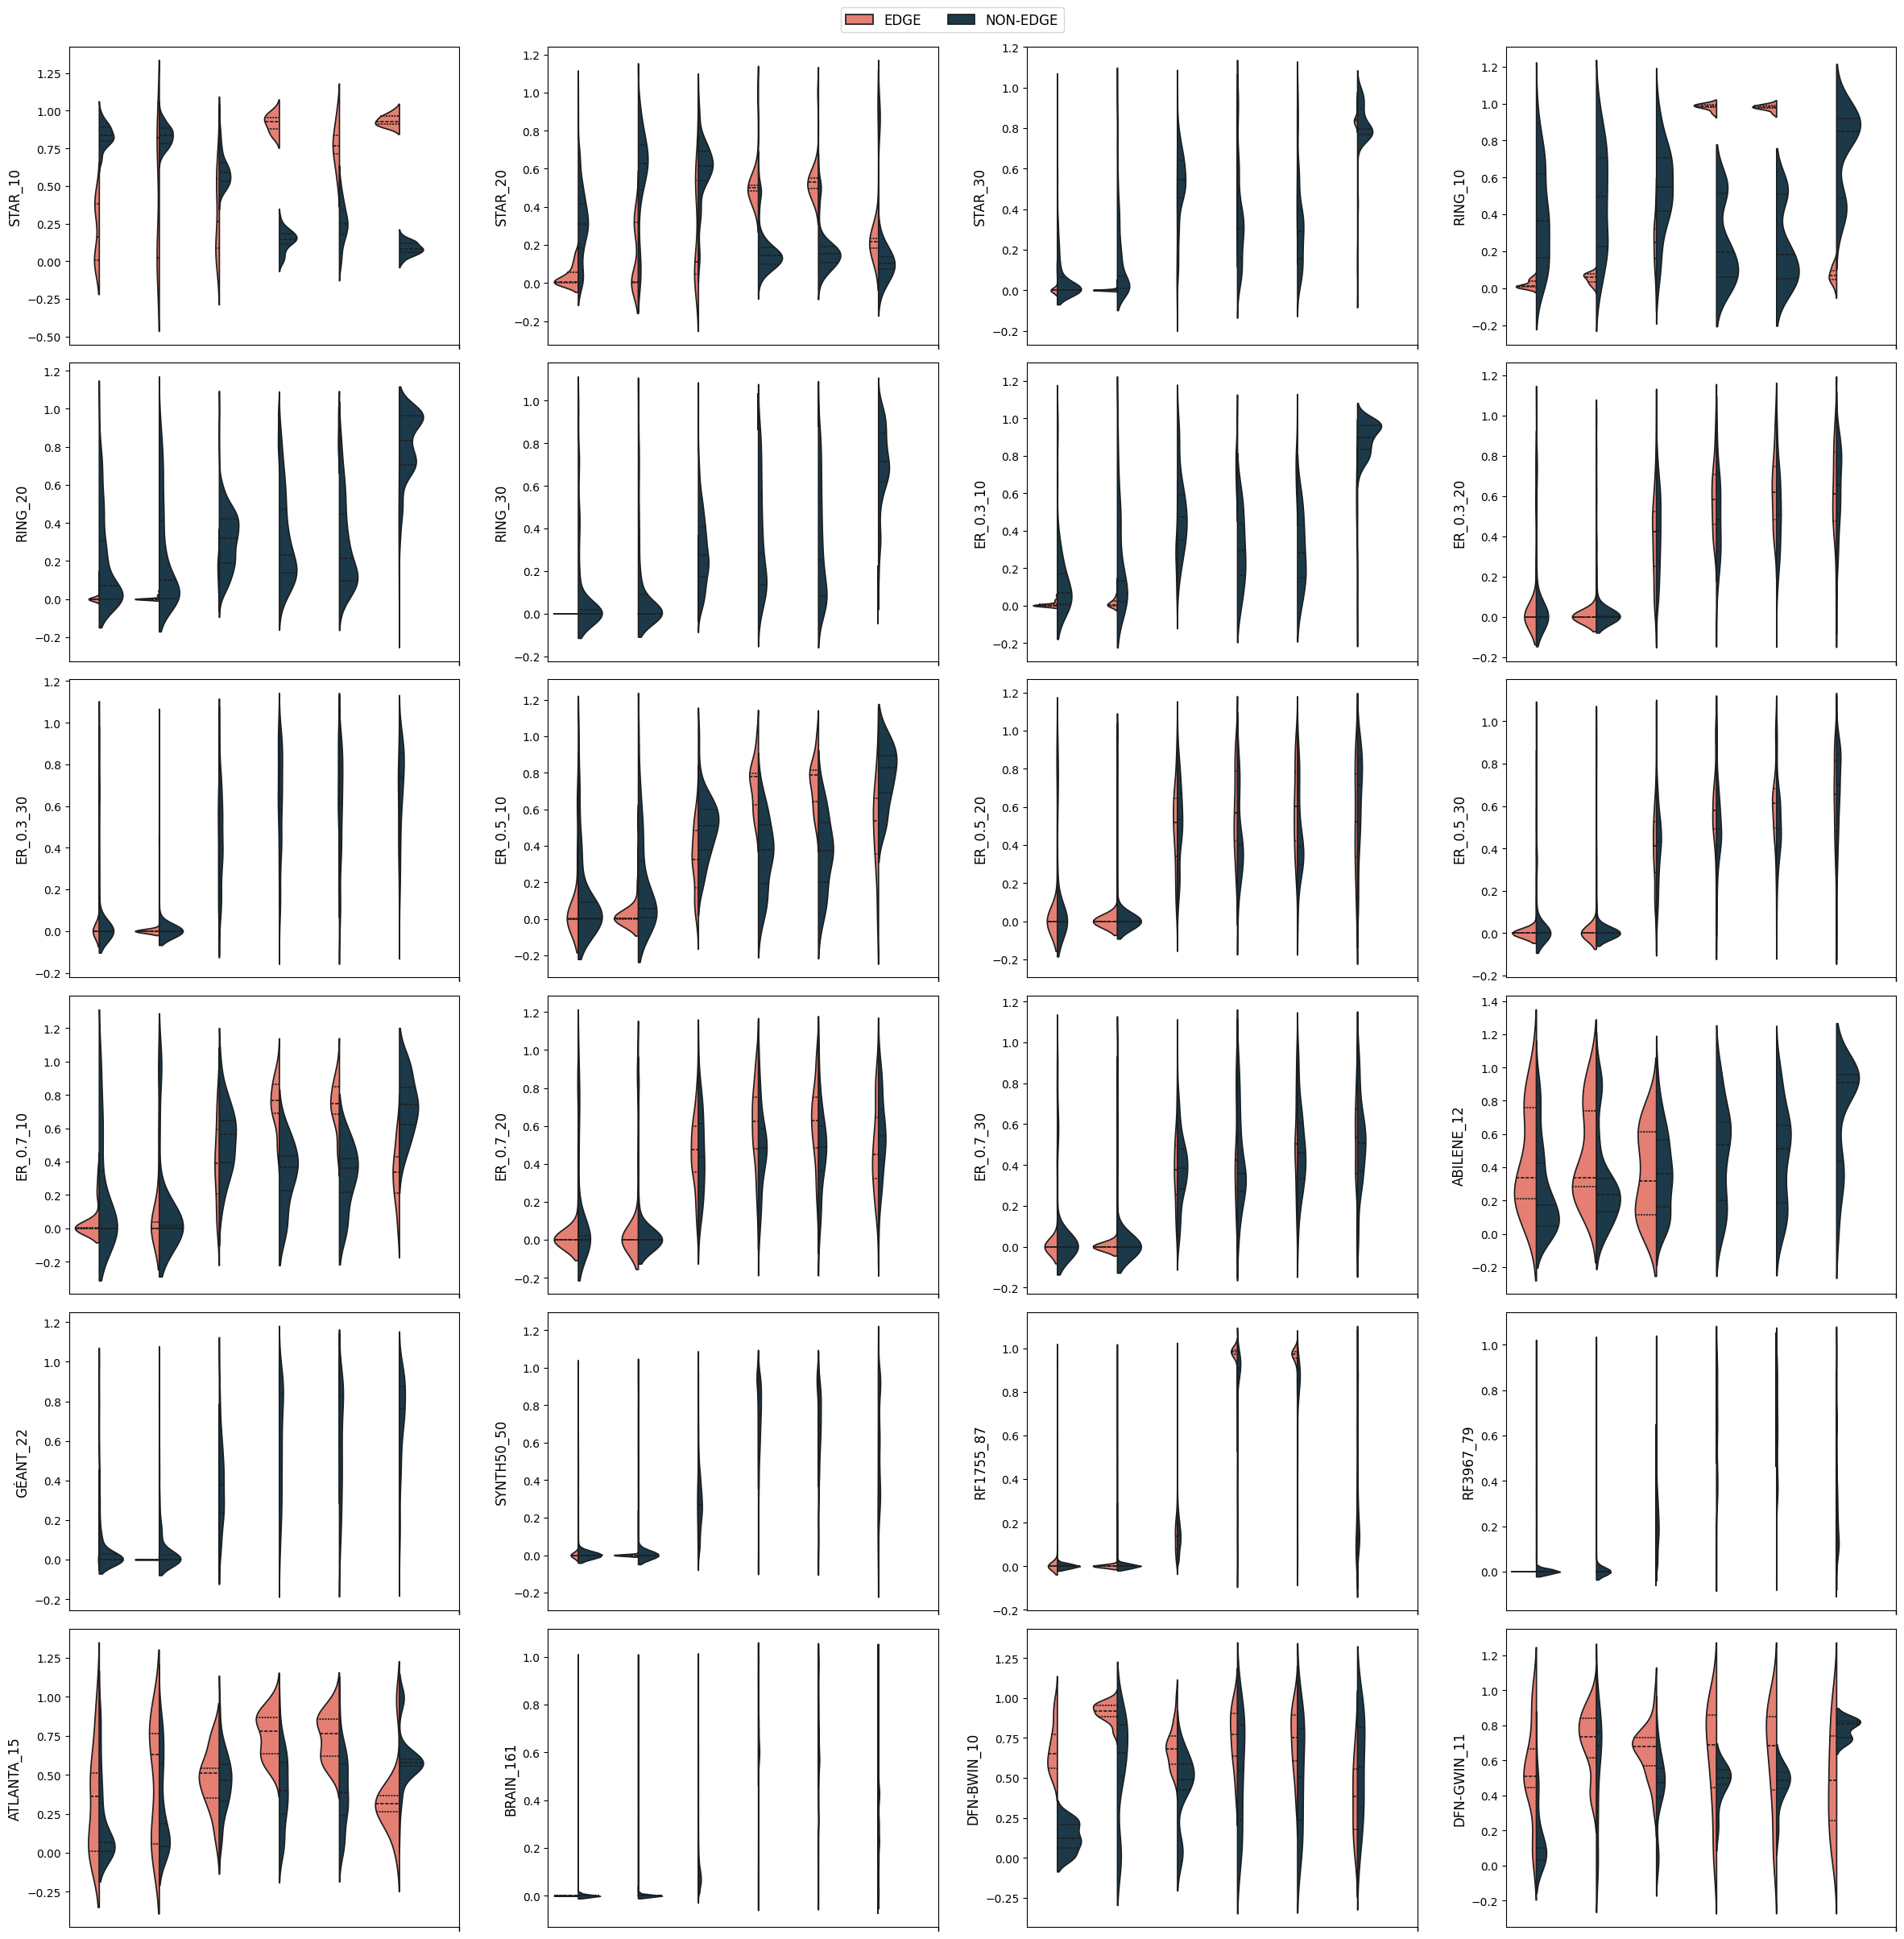

In [19]:
fig, axs = plt.subplots(6,4, layout='constrained', figsize=(24, 24), sharey=False, sharex=True)
palette = ['#F87060','#153B50' ] 
for idx, ddf in enumerate(df_list):
    i = int(idx/4)
    j = int(idx%4)
    
    sns.violinplot(data=ddf, x='ATTACT METRICS', y='Normalized_value', ax=axs[i][j], hue='Connection Type', palette=palette, split=True, inner='quartile')

    # wrapped_labels = [textwrap.fill(label.upper(), 10) for label in df['ATTACT METRICS'].unique()]
    # axs[i][j].set_xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, rotation=0)
    axs[i][j].set_xticks(['','','','',''])
    # if j==10:            
        # axs[i][j].set_xlabel('ATTACK METRICS', fontsize=12)
    
    topo = ddf['topo'][0]
    axs[i][j].set_ylabel(f'{topo.upper()}', fontsize=12)
    axs[i][j].set_xlabel(None)
    
    # dataset_name = dataset
    # if i==0:
    #     if dataset_name=='Cifar10no':                
    #         dataset_name='Cifar10'
    #     axs[i][j].set_title(f'{dataset_name.upper()}', fontsize=12)
    # else:
    #     axs[i][j].set_title(None)
    
    axs[i][j].legend().remove()
    
    # df = None

handles, labels = axs[0][0].get_legend_handles_labels()
labels = [x.upper() for x in labels]
fig.legend(handles, labels,loc='upper center',bbox_to_anchor=(0.5, 1.01), ncol=2, fontsize=12)
plt.tight_layout(pad=2.0, w_pad=2.5, h_pad=1.0)
plt.savefig('image10_all_metrics_distribution.pdf', format='pdf', bbox_inches='tight')

